In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Datasets/steel.csv")
data.head()

,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773


In [3]:
print(data.isnull().sum())

normalising_temperature    0
tempering_temperature      0
percent_silicon            0
percent_chromium           0
percent_copper             0
percent_nickel             0
percent_sulphur            0
percent_carbon             0
percent_manganese          0
tensile_strength           0
dtype: int64


In [4]:
X = data.drop(labels="tensile_strength", axis=1, inplace=False)
y = data["tensile_strength"]

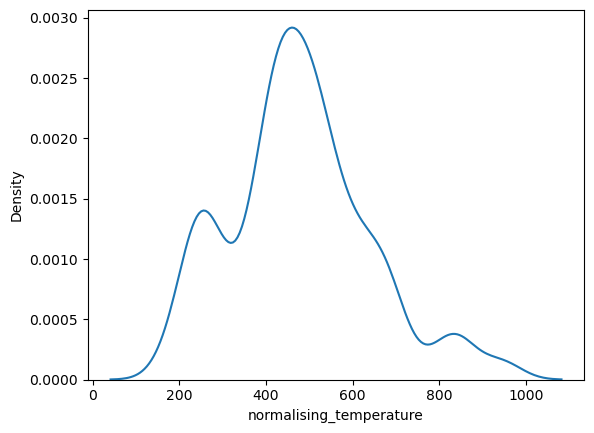

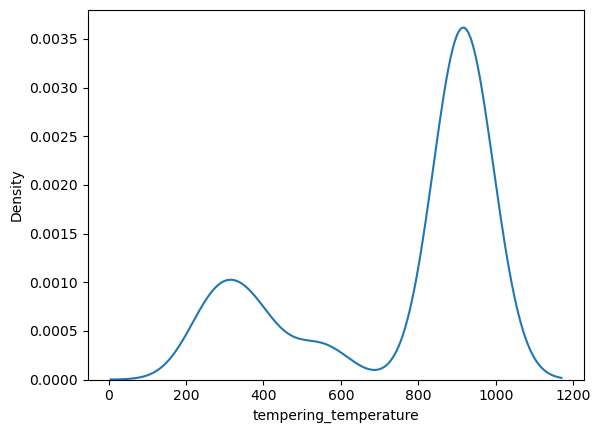

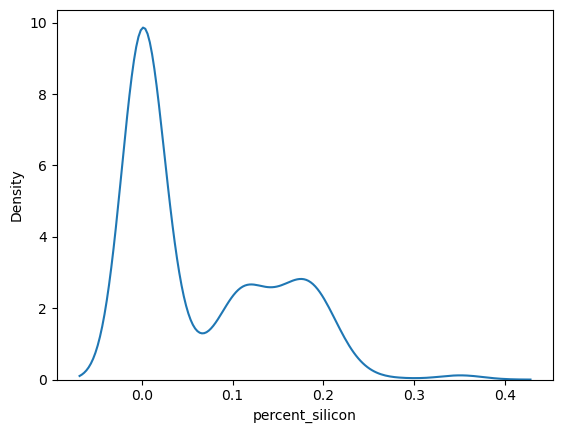

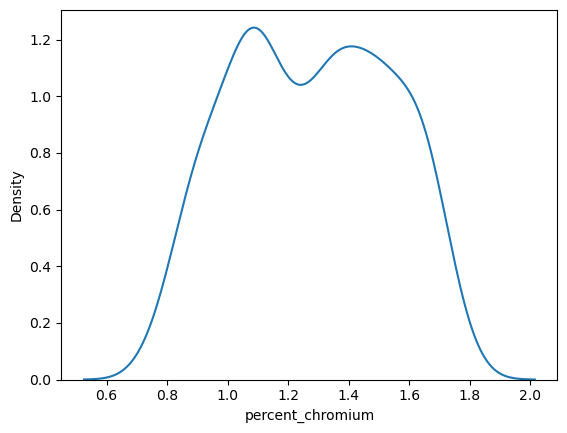

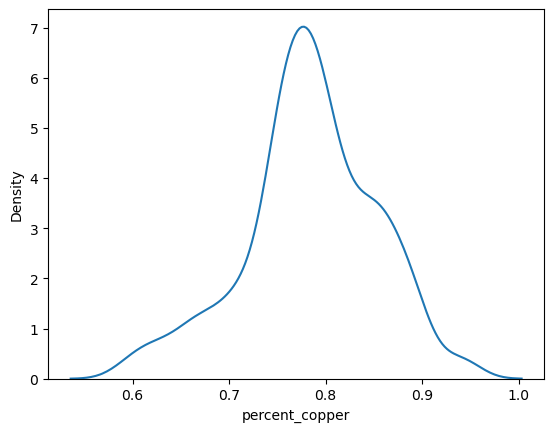

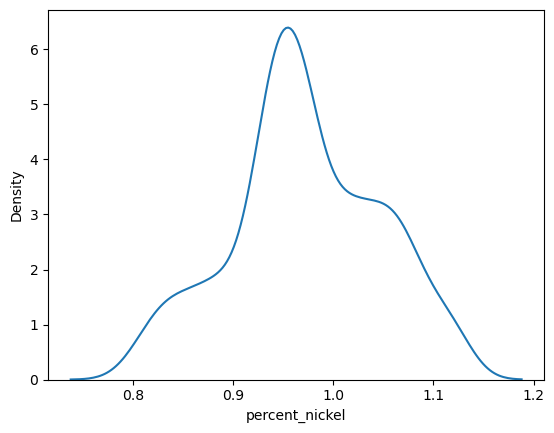

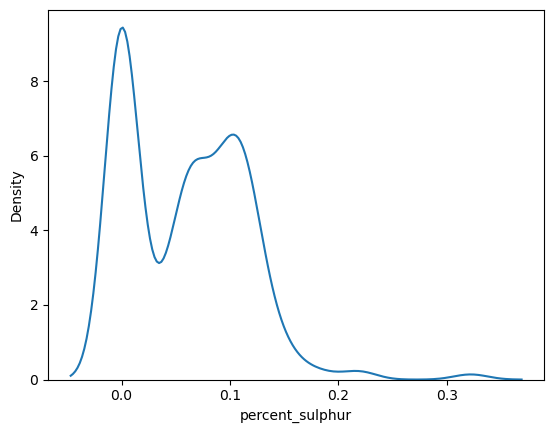

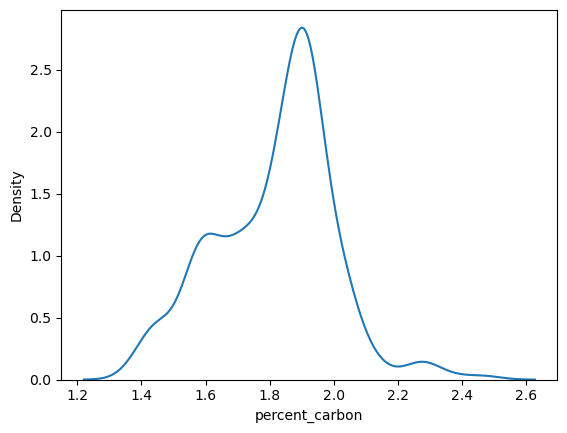

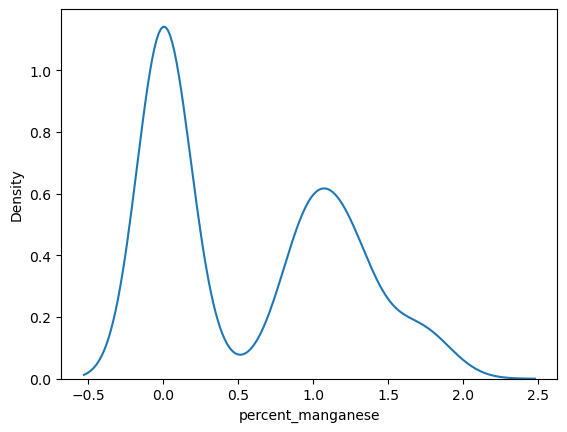

In [5]:
#graph plotting
for col in X.columns:
    sns.kdeplot(X[col])
    plt.show()

In [6]:
#Apply train data on 10 fold cross validation on baseline model

#scale the features(X_train,X_test)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X) 

cv = KFold(n_splits=10, random_state=42, shuffle=True)
model_SVR = SVR()
#applied the measurement of error 
scores = cross_validate(model_SVR,X_scale, y, scoring= {"MSE":"neg_mean_squared_error", "R2":"r2"}, 
                        cv=cv, return_train_score=True,n_jobs=-1)
results_baseline_df = pd.DataFrame(scores)

#change the neg mean square error to positive 
results_baseline_df ['test_MSE']=-results_baseline_df['test_MSE']
results_baseline_df ['train_MSE']=-results_baseline_df['train_MSE']
print(results_baseline_df)

   fit_time  score_time      test_MSE    train_MSE   test_R2  train_R2
0  0.014090    0.004636  10303.426497  5840.433664  0.184019  0.251055
1  0.007205    0.002234   5601.143889  6230.420980  0.172506  0.263662
2  0.007255    0.002872   3954.004972  6530.156695  0.280263  0.241003
3  0.007235    0.002568   7443.406162  6224.793782  0.163308  0.241167
4  0.007378    0.002573   5806.188639  6371.725197  0.240985  0.237862
5  0.007252    0.002465   3789.577259  6545.501187  0.315055  0.237229
6  0.014380    0.004332   5412.815283  6308.968631  0.238109  0.250184
7  0.007497    0.002502   4721.853406  6471.207467  0.312939  0.231585
8  0.013305    0.004098  10837.244186  5854.396732  0.178315  0.241645
9  0.014131    0.004537   5866.298649  6321.663798  0.259177  0.241175


In [7]:
results_baseline_df.describe()

,fit_time,score_time,test_MSE,train_MSE,test_R2,train_R2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.009973,0.003282,6373.595894,6269.926813,0.234467,0.243657
std,0.003457,0.000985,2446.565107,249.324851,0.057751,0.009078
min,0.007205,0.002234,3789.577259,5840.433664,0.163308,0.231585
25%,0.007253,0.002518,4894.593875,6226.200581,0.179741,0.238647
50%,0.007437,0.002723,5703.666264,6315.316214,0.239547,0.241171
75%,0.013894,0.004274,7049.129283,6446.336899,0.274992,0.248049
max,0.014380,0.004636,10837.244186,6545.501187,0.315055,0.263662


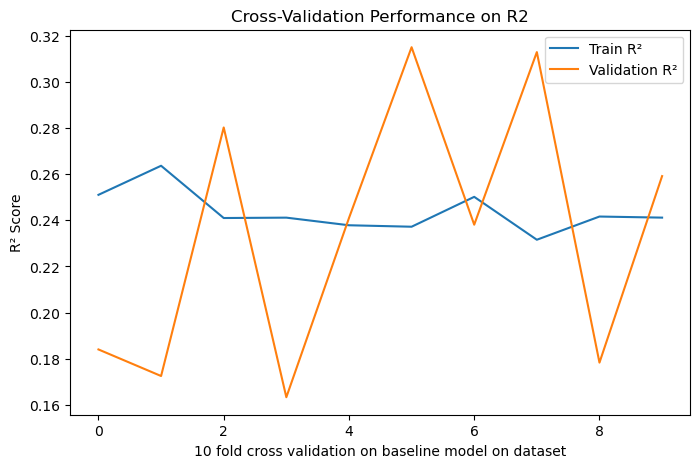

In [8]:
plt.figure(figsize=(8,5))
plt.plot(results_baseline_df['train_R2'], label='Train R²')
plt.plot(results_baseline_df['test_R2'], label='Validation R²')
plt.xlabel('10 fold cross validation on baseline model on dataset')
plt.ylabel('R² Score')
plt.title('Cross-Validation Performance on R2')
plt.legend()
plt.show()

In [9]:
#Hyperparameter tuning
#Define paramater grid 
param_grid ={
    "kernel":["linear","sigmoid","rbf"],
    "epsilon":[0.01, 0.1, 0.5, 1.0]
}

#10 fold cross validation
gs_cv = GridSearchCV(estimator = model_SVR,
                           param_grid=param_grid,
                           scoring = {"MSE":"neg_mean_squared_error", "R2":"r2"},
                           cv=cv,
                           refit="R2",
                           return_train_score=True)

gs_cv.fit(X_scale, y)
results_finetune_df = pd.DataFrame(gs_cv.cv_results_)
#change the neg mean square error to positive 
results_finetune_df['mean_test_MSE']=-results_finetune_df['mean_test_MSE']

print("Best parameters:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)
print(results_finetune_df[['param_kernel', 'param_epsilon', 'mean_test_MSE', 'mean_test_R2']])

Best parameters: {'epsilon': 0.5, 'kernel': 'linear'}
Best score: 0.7446809462353723
   param_kernel  param_epsilon  mean_test_MSE  mean_test_R2
0        linear           0.01    2028.638288      0.744184
1       sigmoid           0.01    4308.685657      0.476787
2           rbf           0.01    6373.285472      0.234471
3        linear           0.10    2027.067294      0.744343
4       sigmoid           0.10    4308.432681      0.476808
5           rbf           0.10    6373.595894      0.234467
6        linear           0.50    2024.299106      0.744681
7       sigmoid           0.50    4310.586830      0.476680
8           rbf           0.50    6375.946437      0.234270
9        linear           1.00    2027.512190      0.744374
10      sigmoid           1.00    4315.729704      0.475991
11          rbf           1.00    6375.992123      0.234191


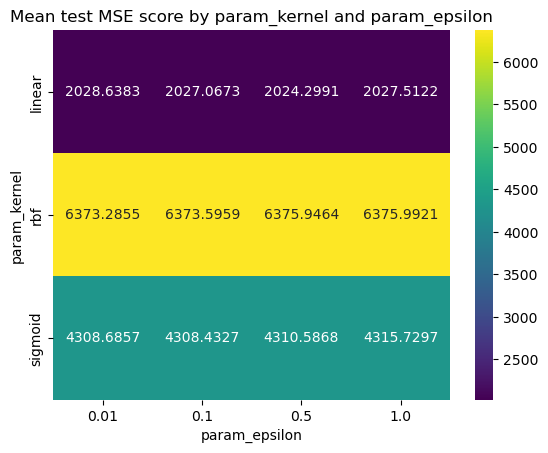

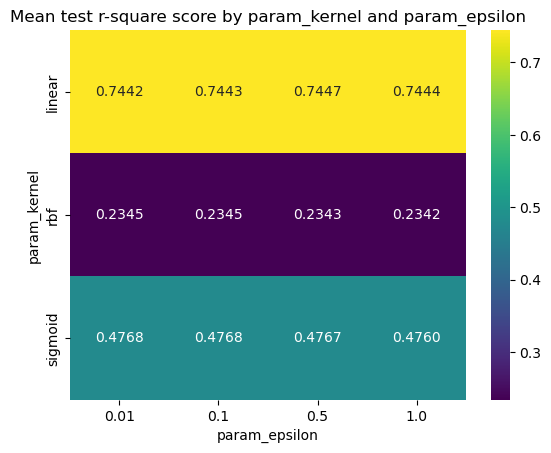

In [10]:
pivot1 = results_finetune_df.pivot(index="param_kernel", columns="param_epsilon", values="mean_test_MSE")
sns.heatmap(pivot1, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test MSE score by param_kernel and param_epsilon")
plt.xlabel("param_epsilon")
plt.ylabel("param_kernel")
plt.show()


pivot2 = results_finetune_df.pivot(index="param_kernel", columns="param_epsilon", values="mean_test_R2")
sns.heatmap(pivot2, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test r-square score by param_kernel and param_epsilon")
plt.xlabel("param_epsilon")
plt.ylabel("param_kernel")
plt.show()

#code reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [11]:
model_MLPR = MLPRegressor()

scores_MLPR = cross_validate(model_MLPR,X_scale, y, scoring= {"MSE":"neg_mean_squared_error", "R2":"r2"}, 
                        cv=cv, return_train_score=True,n_jobs=-1)

results_baseline_df_MLPR = pd.DataFrame(scores)

#change the neg mean square error to positive 
results_baseline_df_MLPR ['test_MSE']=-results_baseline_df_MLPR ['test_MSE']
results_baseline_df_MLPR ['train_MSE']=-results_baseline_df_MLPR ['train_MSE']
print(results_baseline_df_MLPR)

   fit_time  score_time      test_MSE    train_MSE   test_R2  train_R2
0  0.014090    0.004636  10303.426497  5840.433664  0.184019  0.251055
1  0.007205    0.002234   5601.143889  6230.420980  0.172506  0.263662
2  0.007255    0.002872   3954.004972  6530.156695  0.280263  0.241003
3  0.007235    0.002568   7443.406162  6224.793782  0.163308  0.241167
4  0.007378    0.002573   5806.188639  6371.725197  0.240985  0.237862
5  0.007252    0.002465   3789.577259  6545.501187  0.315055  0.237229
6  0.014380    0.004332   5412.815283  6308.968631  0.238109  0.250184
7  0.007497    0.002502   4721.853406  6471.207467  0.312939  0.231585
8  0.013305    0.004098  10837.244186  5854.396732  0.178315  0.241645
9  0.014131    0.004537   5866.298649  6321.663798  0.259177  0.241175


In [12]:
results_baseline_df_MLPR.describe()

,fit_time,score_time,test_MSE,train_MSE,test_R2,train_R2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.009973,0.003282,6373.595894,6269.926813,0.234467,0.243657
std,0.003457,0.000985,2446.565107,249.324851,0.057751,0.009078
min,0.007205,0.002234,3789.577259,5840.433664,0.163308,0.231585
25%,0.007253,0.002518,4894.593875,6226.200581,0.179741,0.238647
50%,0.007437,0.002723,5703.666264,6315.316214,0.239547,0.241171
75%,0.013894,0.004274,7049.129283,6446.336899,0.274992,0.248049
max,0.014380,0.004636,10837.244186,6545.501187,0.315055,0.263662


In [16]:
param_grid_MLPR ={
    "hidden_layer_sizes": [(50,), (100,), (50,50)],
    "solver":["adam","lbfgs", "sgd"]
}

#10 fold cross validation
gs_cv_MLPR = GridSearchCV(estimator = model_MLPR,
                           param_grid=param_grid_MLPR,
                           scoring = {"MSE":"neg_mean_squared_error", "R2":"r2"},
                           cv=cv,
                           refit="R2",
                           return_train_score=True)

gs_cv_MLPR.fit(X_scale, y)
results_finetune_df_MLPR = pd.DataFrame(gs_cv_MLPR.cv_results_)
#change the neg mean square error to positive 
results_finetune_df_MLPR['mean_test_MSE']=-results_finetune_df_MLPR['mean_test_MSE']

print("Best parameters:", gs_cv_MLPR.best_params_)
print("Best score:", gs_cv_MLPR.best_score_)
print(results_finetune_df_MLPR[['param_hidden_layer_sizes', 'param_solver', 'mean_test_MSE', 'mean_test_R2']])

C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer

Best parameters: {'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
Best score: 0.8660804484297205
  param_hidden_layer_sizes param_solver  mean_test_MSE  mean_test_R2
0                    (50,)         adam   24364.498128     -2.122854
1                    (50,)        lbfgs    1006.175862      0.863146
2                    (50,)          sgd    1218.668797      0.839069
3                   (100,)         adam   12337.979105     -0.615330
4                   (100,)        lbfgs    1035.146424      0.866080
5                   (100,)          sgd    1131.533640      0.853298
6                 (50, 50)         adam    2415.975159      0.689223
7                 (50, 50)        lbfgs    1028.014178      0.862542
8                 (50, 50)          sgd            NaN           NaN


C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
